## Infomap + NetworkX
Generate and draw a network with NetworkX, colored
according to the community structure found by Infomap.


In [140]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import pandas as pd
%pyplot


UsageError: Line magic function `%pyplot` not found.


In [141]:
infomap_path = '~/infomap/Infomap'

def infomap(net_path, altmap=False):
    out_path = './results/'
    args = '-2 -u'
    if altmap:
        args += ' --altmap'
        
    os.system(infomap_path + ' ' + net_path + ' ' + out_path + ' ' + args)

def read_tree(tree_path):    
    df = pd.read_csv(tree_path, sep=' ', header = 1)
    df.columns = ['community', 'flow', 'name', 'node', 'trash']
    df = df.drop(['flow', 'trash'], axis=1)
    
    for i, path in enumerate(df['community']):
        df.iloc[i,0] = path[0]
        
    return df

def drawNetwork(G):
    # position map
    pos = nx.spring_layout(G)
    # community ids
    communities = [v for k,v in nx.get_node_attributes(G, 'community').items()]
    numCommunities = max(communities) + 1
    # color map from http://colorbrewer2.org/
    cmapLight = colors.ListedColormap(['#a6cee3', '#b2df8a', '#fb9a99', '#fdbf6f', '#cab2d6'], 'indexed', numCommunities)
    cmapDark = colors.ListedColormap(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00', '#6a3d9a'], 'indexed', numCommunities)

    # Draw edges
    nx.draw_networkx_edges(G, pos)

    # Draw nodes
    nodeCollection = nx.draw_networkx_nodes(G,
        pos = pos,
        node_color = communities,
        cmap = cmapLight
    )
    # Set node border color to the darker shade
    darkColors = [cmapDark(v) for v in communities]
    nodeCollection.set_edgecolor(darkColors)

    # Draw node labels
    for n in G.nodes():
        plt.annotate(n,
            xy = pos[n],
            textcoords = 'offset points',
            horizontalalignment = 'center',
            verticalalignment = 'center',
            xytext = [0, 0],
            color = cmapDark(communities[int(n) - 1])
        )

    plt.axis('off')
    # plt.savefig("karate.png")
    plt.show()


In [147]:


net_path = './rings.net'
infomap(net_path, altmap=False)



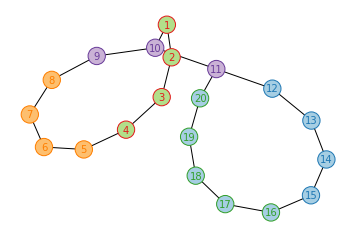

In [148]:

tree_path = './results/rings.tree'
df = read_tree(tree_path)

G = nx.read_pajek(net_path)

communities = {}
for index, row in df.iterrows():
    node = str(row['node'])
    communities[node] = int(row['community'])

nx.set_node_attributes(G, name='community', values=communities)

# print network
drawNetwork(G)
